# Argo Vertical Spectra

This notebook is based on Dhruv's vertical_spectra notebook with glider data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

### Useful functions (separate for glider & argo)

In [2]:
def glider_ds_filt(ds_interp,first,last,num,variable='CT'):
    temp_sigmas=np.logspace(first,last,num)
    sigmas=np.empty(num)
    for n,sig in enumerate(temp_sigmas):
        sigmas[n]=sig/4/np.sqrt(12)
        
    temp_filt=np.zeros((ds_interp.ctd_pressure.shape[0],ds_interp.dives.shape[0],num))
    for n in range(0,num):
        temp_filt[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')
    ds_filt=xr.DataArray(temp_filt,dims=['ctd_pressure','dives','filt_scale'],
        coords={'ctd_pressure':ds_interp.ctd_pressure,'dives':ds_interp.dives,'filt_scale':sigmas})
    return ds_filt

def glider_var(ds_interp,ds_filt,variable='CT'):
    var=np.zeros(len(ds_filt.filt_scale))
    for n,sig in enumerate(ds_filt.filt_scale):
        prof_filt=ds_filt.sel(filt_scale=sig)
        var[n]=(prof_filt-ds_interp.CT).var()
    return var

In [3]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2)) #is this where we lose other variables?
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    
    number=np.arange(0,len(ds_interp.N_PROF))
    ds_interp.coords['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)
    return ds_interp

def get_ds_filt(ds_interp,first,last,num,variable='TEMP'):
    temp_sigmas=np.logspace(first,last,num)
    sigmas=np.empty(num)
    for n,sig in enumerate(temp_sigmas):
        sigmas[n]=sig/4/np.sqrt(12)
    
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))
    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    return ds_filt

def get_var(ds_interp,ds_filt,variable='TEMP'):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(ds_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp[variable]).var()
    return var

### Glider data, filtering & spectra

In [4]:
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
ds_660_filt=glider_ds_filt(ds_660_grid,1,4,50)
ds_660_var=glider_var(ds_660_grid,ds_660_filt)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, 

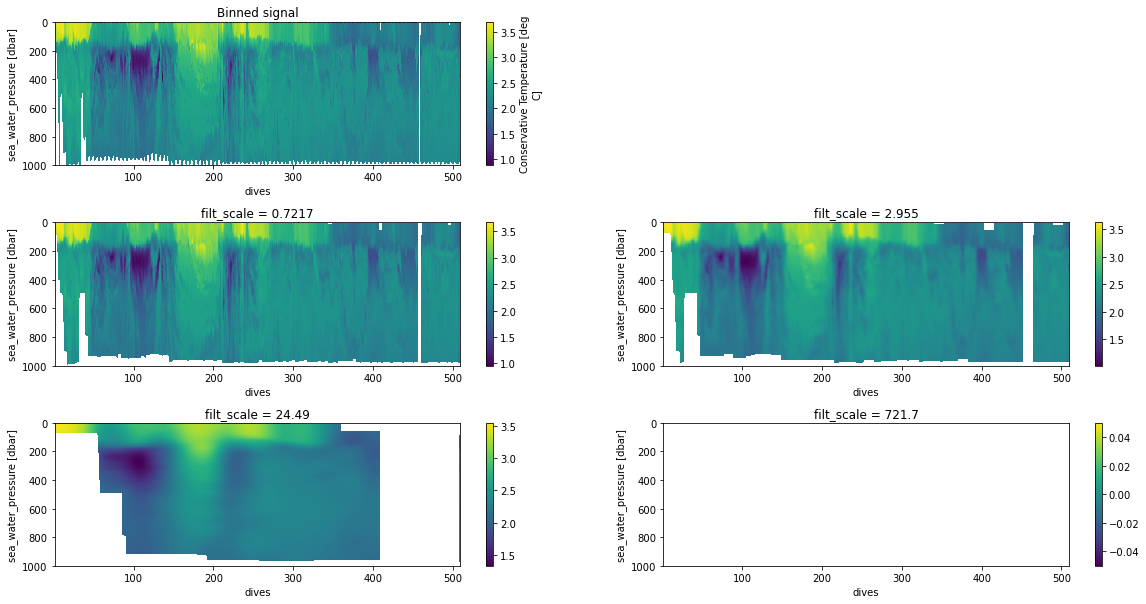

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
ds_660_grid.CT.plot(x='dives',y='ctd_pressure')
plt.gca().invert_yaxis()
plt.title('Binned signal')

plt.subplot(3,2,3)
ds_660_filt.isel(filt_scale=0).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,4)
ds_660_filt.isel(filt_scale=10).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,5)
ds_660_filt.isel(filt_scale=25).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,6)
ds_660_filt.isel(filt_scale=49).plot()
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.4,wspace=0.2)

In [6]:
select=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))
select_filt=glider_ds_filt(select,1,3,50)
select_var=glider_var(select,select_filt)

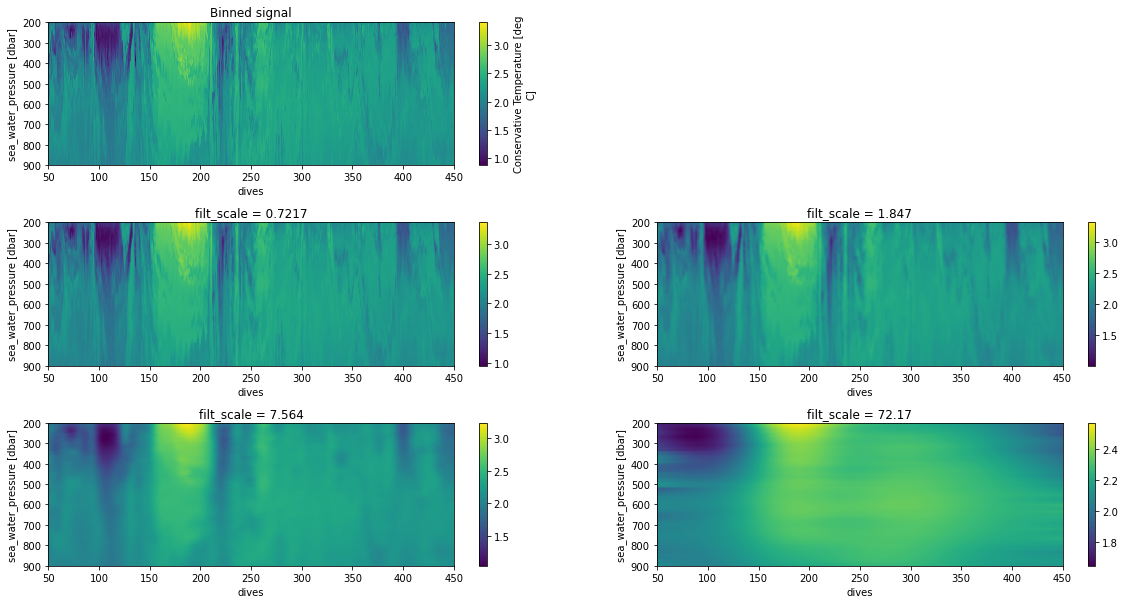

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
select.CT.plot(x='dives',y='ctd_pressure')
plt.gca().invert_yaxis()
plt.title('Binned signal')

plt.subplot(3,2,3)
select_filt.isel(filt_scale=0).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,4)
select_filt.isel(filt_scale=10).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,5)
select_filt.isel(filt_scale=25).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,6)
select_filt.isel(filt_scale=49).plot()
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.4,wspace=0.2)

Text(0, 0.5, 'Variance ($^oC^2$)')

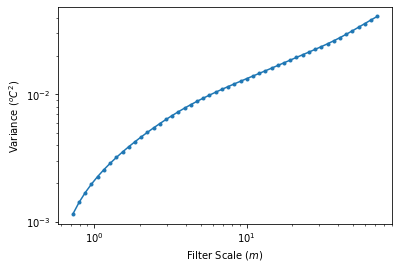

In [8]:
plt.plot(select_filt.filt_scale,select_var,'.-')

#kz = select_filt.freq_ctd_pressure
#plt.plot(kz, 1e-7*kz**(-2), '--', label='-2')
#plt.plot(kz, 1e-10*kz**(-3), '--', label='-3')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")

In [9]:
select_CT_spec=xrft.power_spectrum(select.CT.dropna(dim='dives') - select.CT.mean('dives'),
                                     dim='ctd_pressure', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


Text(0.5, 0, '$\\lambda$ [1/m]')

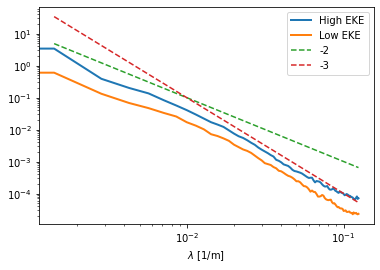

In [10]:
select_CT_spec.sel(dives=slice(0,250)).mean('dives').plot(label='High EKE', linewidth=2)
select_CT_spec.sel(dives=slice(250,500)).mean('dives').plot(label='Low EKE', linewidth=2)

kz = select_CT_spec.freq_ctd_pressure

plt.plot(kz, 1e-5*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-7*kz**(-3), '--', label='-3')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

Text(0.5, 0, '$\\lambda$ [1/m]')

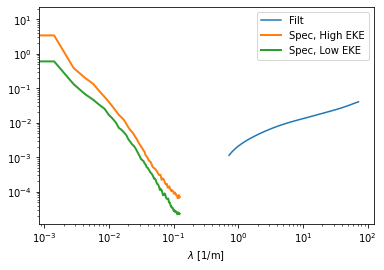

In [11]:
plt.plot(select_filt.filt_scale,select_var,label='Filt')

select_CT_spec.sel(dives=slice(0,250)).mean('dives').plot(label='Spec, High EKE', linewidth=2)
select_CT_spec.sel(dives=slice(250,500)).mean('dives').plot(label='Spec, Low EKE', linewidth=2)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

### Argo data, filtering & Spectra

In [12]:
box=xr.open_dataset('202206_lon:(30,39)_lat:(-54,-50).nc')
box_interp=get_ds_interp(box,200,1000,4)
box_filt=get_ds_filt(box_interp,1,3,50)
box_var=get_var(box_interp,box_filt)

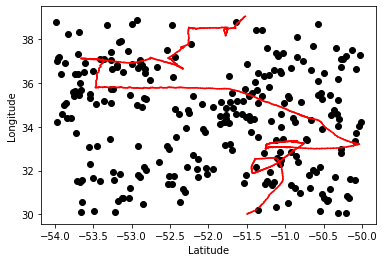

In [13]:
plt.scatter(box_interp.LATITUDE,box_interp.LONGITUDE,color='black',label='argo profiles')
plt.plot(ds_660_grid.latitude, ds_660_grid.longitude,color='r',label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude');

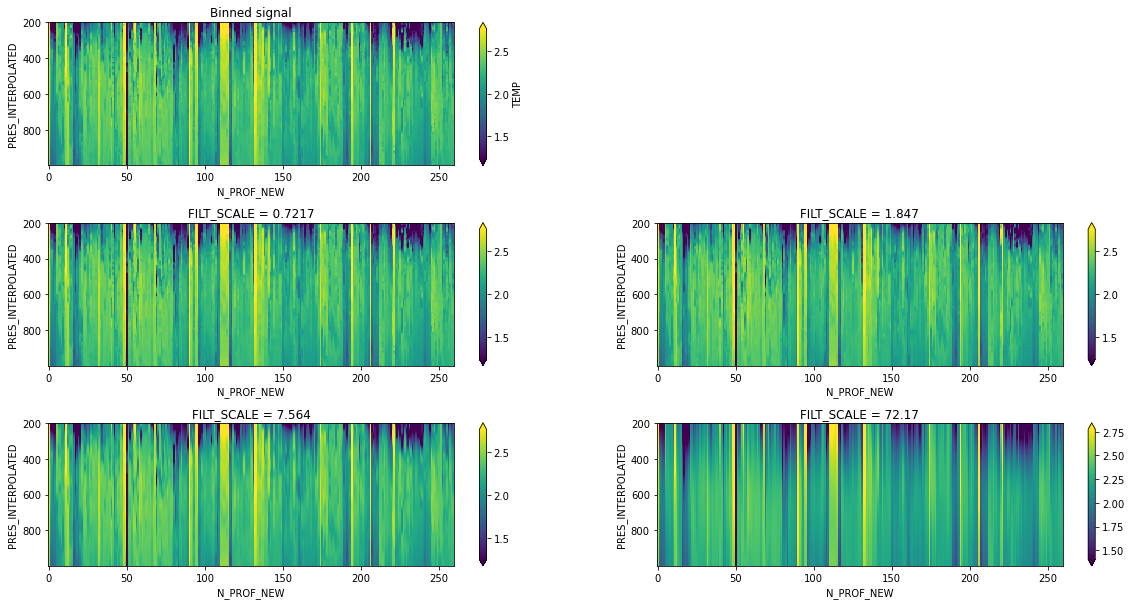

In [14]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
box_interp.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()
plt.title('Binned signal')

plt.subplot(3,2,3)
box_filt.isel(FILT_SCALE=0).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

plt.subplot(3,2,4)
box_filt.isel(FILT_SCALE=10).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

plt.subplot(3,2,5)
box_filt.isel(FILT_SCALE=25).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

plt.subplot(3,2,6)
box_filt.isel(FILT_SCALE=49).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.4,wspace=0.2)

Text(0, 0.5, 'Variance ($^oC^2$)')

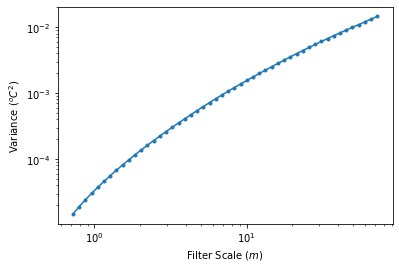

In [15]:
plt.plot(box_filt.FILT_SCALE,box_var,'.-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")

In [16]:
box_TEMP_spec=xrft.power_spectrum(box_interp.TEMP - box_interp.TEMP.mean('N_PROF'),
                                     dim='PRES_INTERPOLATED', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


Text(0.5, 0, '$\\lambda$ [1/m]')

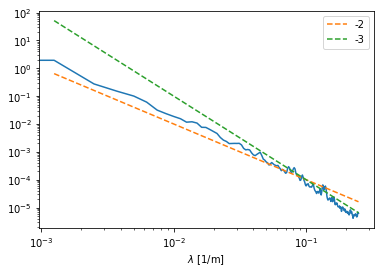

In [17]:
box_TEMP_spec.mean('N_PROF').plot()

kz = box_TEMP_spec.freq_PRES_INTERPOLATED

plt.plot(kz, 1e-6*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-7*kz**(-3), '--', label='-3')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

Text(0, 0.5, 'Variance ($^oC^2$)')

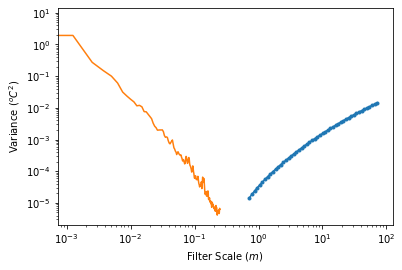

In [18]:
plt.plot(box_filt.FILT_SCALE,box_var,'.-')
box_TEMP_spec.mean('N_PROF').plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")